adapted from https://harvard-iacs.github.io/2021-CS109B/lectures/lecture13/notebook/#2

## Given different choice options, how does Fixation Number affects Fixation Duration? 
### Does repeated fixation equals greater interests?

In [1]:
import pandas as pd
import numpy as np
df = pd.read_csv('converted_data.csv')

chip_df = df[df['SubjectNumber']=='181002_Chip']

In [2]:
newchip_dfix=[]
for a in range(len(chip_df)):
    if len(chip_df.iloc[:,10][a])== 5:
        newchip_dfix.append(a)

newchipdf = chip_df.loc[newchip_dfix] #only choosing trials with 2 choices
newchipdf.head()

,SubjectNumber,TrialNumber,Choice,RT,FixationNumber,FixationStartTime,FixationEndTime,FixationDuration,FixationOptionLocation,FixationAttributeLocation,ChoiceOptions
0,181002_Chip,3,4,370.894823,1,-293,149,442,NaN,NaN,[6;4]
1,181002_Chip,3,4,370.894823,2,181,371,190,4.0,1.0,[6;4]
3,181002_Chip,5,5,373.807764,1,-475,211,686,NaN,NaN,[1;5]
4,181002_Chip,5,5,373.807764,2,253,374,121,NaN,NaN,[1;5]
7,181002_Chip,13,5,304.040537,1,-848,144,992,NaN,NaN,[5;3]


## 1. Pooling: Same Linear Regression for all choice options

Estimate one big regression to asses the influence of the Fixation Number to Fixation Duration.

$$
 y_i=α+β * trials_i
$$

where trials = 1,2,3. By ignoring the choice options, we do not differenciate fixation choice.

In [3]:
import pymc as pm
from pymc import summary
import arviz as az
from matplotlib import gridspec

In [4]:
with pm.Model() as pooled_model:
    # common priors for all
    a = pm.Normal('a', mu=0, sigma=100)
    b = pm.Normal('b', mu=0, sigma=100)

    # duration estimate
    dur_est = a + b*newchipdf['FixationNumber']

    # likelihood after radon observations
    dur_obs = pm.Normal('dur_obs', mu=dur_est,
                           observed=newchipdf['FixationDuration']) # note here we enter the whole dataset

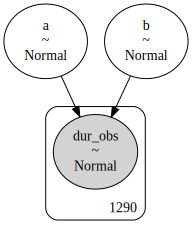

In [5]:
pm.model_to_graphviz(pooled_model)

In [6]:
with pooled_model:

    pooled_trace = pm.sample(2000, tune=1000, target_accept=0.9)
    print(f'DONE')

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, b]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 36 seconds.


DONE


<Figure size 640x480 with 0 Axes>

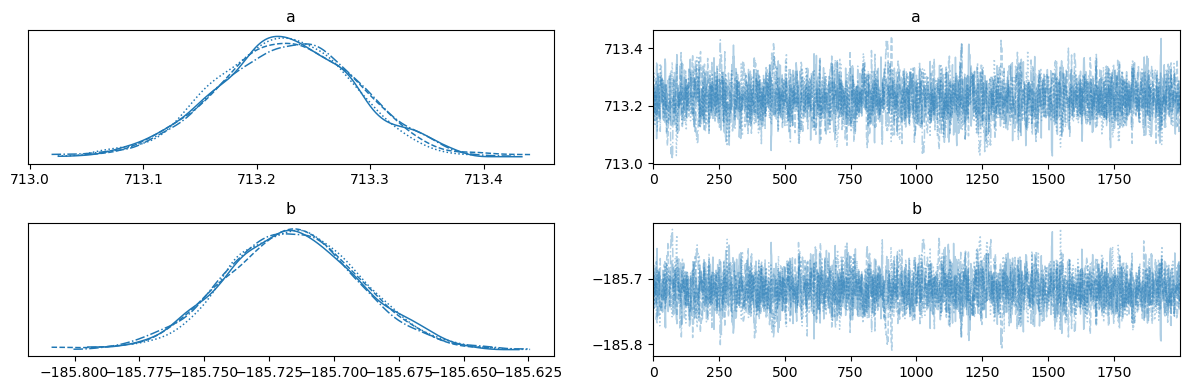

In [7]:
import matplotlib.pyplot as plt
fig = plt.figure()
pm.plot_trace(pooled_trace);
fig = plt.gcf()
fig.tight_layout()
plt.show()

Conclusion: Graph on the left: lines were not so similar for the intercept α, but is okay for the slope β. Graph on the right also showed that they are noisy enough.

## 2. Hierarchical Regression/ Partial pooling: Nested Choices


Since fixation at the same choices options have similarities in the brain, we should account for that. Thus while we assume that while $α_c$ and $β_c$ are different for each choice option as in the unpooled case, the coefficients are all drawn from the same distribution:

$$
duration_i = α_c+β_c ∗ fixnum_i,_c
$$

$$
a_c∼N(μ_a,σ^2_a)
$$

$$
b_c∼N(μ_b,μ_b)
$$

where the common parameters are:


$$
μ_a∼N(0,10)
$$

$$
σ^2_a∼|N(0,10)|
$$

$$
μ_b∼N(0,10)
$$

$$
μ_b∼|N(0,10)|
$$

The different choice options are effectively sharing information through the common priors.

In [8]:
n_choices = len(newchipdf.Choice.unique())
choices = newchipdf.Choice.unique()
choice_idx= newchipdf.Choice.values

In [9]:
with pm.Model() as hierarchical_model:
    # Hyperpriors for group nodes
    mu_a = pm.Normal('mu_a', mu=0., sigma=100)
    sigma_a = pm.HalfNormal('sigma_a', 5.)
    mu_b = pm.Normal('mu_b', mu=0., sigma=100)
    sigma_b = pm.HalfNormal('sigma_b', 5.)

    # Above we just set mu and sd to a fixed value while here we
    # plug in a common group distribution for all a and b (which are
    # vectors of length n_choices).

    # Intercept for each choice, distributed around group mean mu_a
    a = pm.Normal('a', mu=mu_a, sigma=sigma_a, shape=n_choices)

    # beta for each choice, distributed around group mean mu_b
    b = pm.Normal('b', mu=mu_b, sigma=sigma_b, shape=n_choices)


    # duration estimate
    dur_est = a[choice_idx-1] + b[choice_idx-1]*newchipdf['FixationNumber'].values

    # likelihood
    dur_like = pm.Normal('dur_like', mu=dur_est,
                           observed=newchipdf['FixationDuration']) # note here we enter the whole dataset

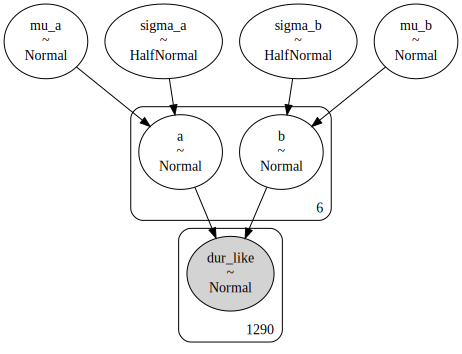

In [10]:
pm.model_to_graphviz(hierarchical_model)

In [11]:
%%time

with hierarchical_model:
    hierarchical_trace = pm.sample(10000, tune=5000, target_accept=.9)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_a, sigma_a, mu_b, sigma_b, a, b]


Output()

Sampling 4 chains for 5_000 tune and 10_000 draw iterations (20_000 + 40_000 draws total) took 83 seconds.


CPU times: user 16.2 s, sys: 2.4 s, total: 18.6 s
Wall time: 1min 26s


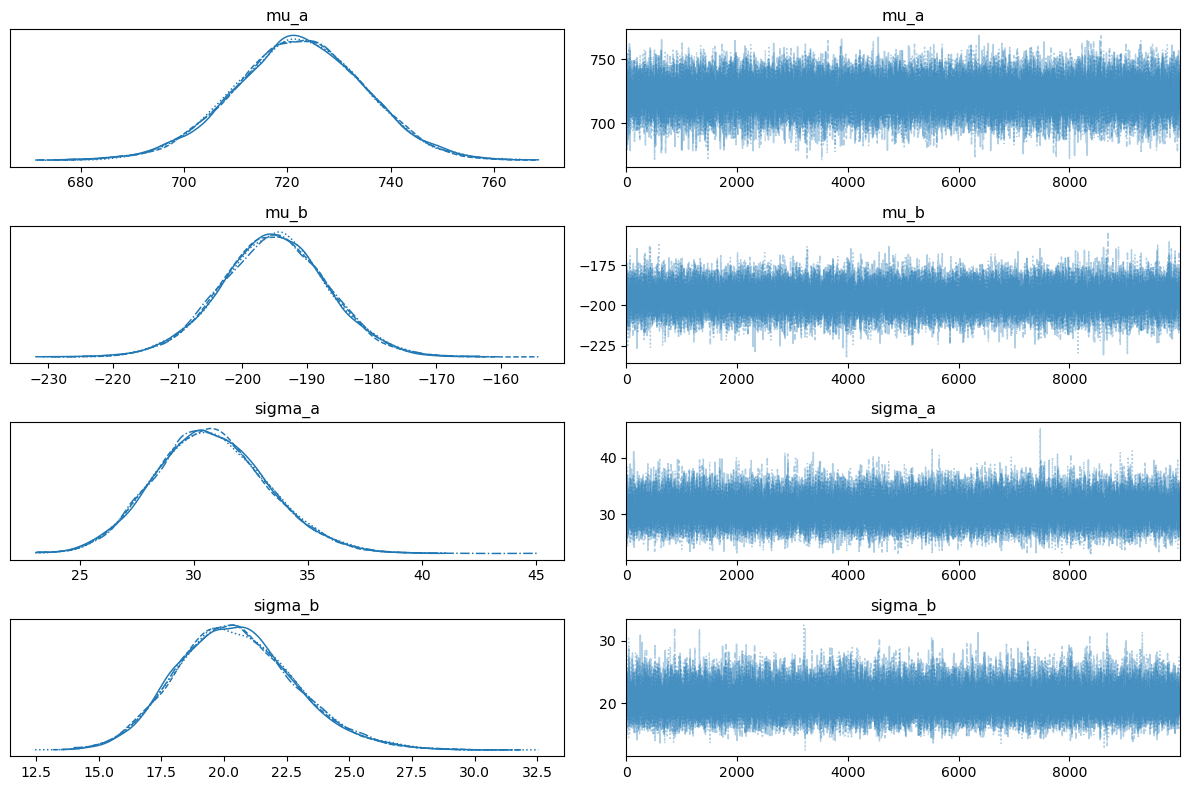

In [12]:
pm.plot_trace(hierarchical_trace, var_names=['mu_a', 'mu_b',
                                            'sigma_a', 'sigma_b']);
fig = plt.gcf()
fig.tight_layout()
plt.show()

In [13]:
results = pm.summary(hierarchical_trace)

In [14]:
results

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu_a,722.257,12.659,698.288,745.820,0.056,0.040,50754.0,30123.0,1.0
mu_b,-195.126,8.324,-211.164,-179.683,0.036,0.026,52294.0,28547.0,1.0
a[0],893.508,0.184,893.162,893.855,0.001,0.001,31103.0,29648.0,1.0
a[1],714.502,0.171,714.178,714.819,0.001,0.001,34406.0,30111.0,1.0
a[2],749.711,0.142,749.442,749.976,0.001,0.001,33293.0,28696.0,1.0
a[3],629.281,0.128,629.042,629.525,0.001,0.000,33401.0,29620.0,1.0
a[4],706.546,0.170,706.222,706.863,0.001,0.001,32341.0,29525.0,1.0
a[5],709.052,0.171,708.729,709.369,0.001,0.001,30987.0,29424.0,1.0
b[0],-267.503,0.082,-267.652,-267.345,0.000,0.000,31528.0,29270.0,1.0
b[1],-202.663,0.076,-202.804,-202.520,0.000,0.000,34238.0,30070.0,1.0
